----------
# Problem 1
--------------

In [1]:
import random
random.seed(123)

## Importing required libraries

In [2]:
# import important libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import time, math
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, classification_report
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns
import copy


In [3]:
df_cicid = pd.read_csv("cicids_static_data.csv")

In [4]:
# Replacing infinite with nan
df_cicid.replace([ np.inf , -np.inf ] , np.nan, inplace=True)
  
# Dropping all the rows with nan values
df_cicid=df_cicid.dropna( axis=0, how='any', thresh=None, subset=None, inplace=False)


In [5]:
df_cicid.isnull().sum().sum()

0

In [6]:
#Converting categorical to numeric without Label or hot encoding just to confirm numbers assigned does not change

df_cicid["Label"].replace({"ATTACK": 1, "BENIGN": 0}, inplace=True)

In [7]:
X, y = df_cicid.iloc[:, :-1], df_cicid.iloc[:, -1]

In [8]:
# # Split dataset into train and test and validation

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split( X, y, train_size=0.8, random_state=42, stratify=y)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem,random_state=42)


In [9]:
y_train.value_counts()

0    18189
1     1954
Name: Label, dtype: int64

In [10]:
#Normalization for the data

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
X_valid = pd.DataFrame(scaler.transform(X_valid))

In [11]:
#Copying the training set to use it later for the dynamic case

X_train2 =  copy.deepcopy( X_train  )
y_train2 =  copy.deepcopy( y_train  )


In [12]:
#Confusion matrix for function 

def plot_conf(y_true,y_predict):
    plt.figure(figsize=[20, 7])
    plt.subplot(1,2,1)
    title = 'Confusion matrix '
    sns.heatmap(confusion_matrix(y_true, y_predict), annot=True, fmt='')
    plt.title(title)
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

    return

In [13]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(max_iter=1000, tol=0.01,random_state=0)
 
sgdc.fit(X_train, y_train)

y_sgdc= sgdc.predict(X_test)


y_sgdc_valid=sgdc.predict(X_valid)

print(classification_report(y_valid, y_sgdc_valid))
print('------------')
print('acc of validation :',accuracy_score(y_valid, y_sgdc_valid)*100)



              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2273
           1       0.84      0.69      0.76       245

    accuracy                           0.96      2518
   macro avg       0.90      0.84      0.87      2518
weighted avg       0.95      0.96      0.95      2518

------------
acc of validation : 95.67116759332805


acc of testing : 94.758
------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2274
           1       0.79      0.62      0.70       244

    accuracy                           0.95      2518
   macro avg       0.88      0.80      0.83      2518
weighted avg       0.94      0.95      0.94      2518



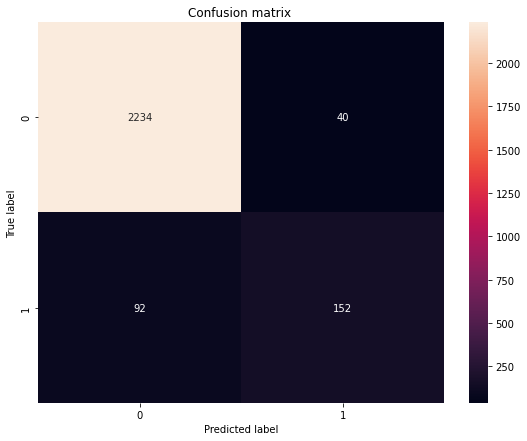

In [14]:
print('acc of testing :',round(accuracy_score(y_test, y_sgdc),5)*100)
print('------------')
print(classification_report(y_test, y_sgdc))

plot_conf(y_test, y_sgdc)


In [15]:
#Model
dt=DecisionTreeClassifier(criterion='entropy',class_weight='balanced',max_depth=15,random_state=0)
dt2=DecisionTreeClassifier(criterion='entropy',class_weight='balanced',max_depth=15,random_state=0)

#Train the model using the training sets 

#for static later
dt.fit(X_train,y_train)
# for dynamic
dt2.fit(X_train2, y_train2)


y_dt=dt.predict(X_test)
y_dt_valid=dt.predict(X_valid)

print(classification_report(y_valid, y_dt_valid))
print('------------')
print('acc of validation :',accuracy_score(y_valid, y_dt_valid)*100)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2273
           1       0.98      1.00      0.99       245

    accuracy                           1.00      2518
   macro avg       0.99      1.00      0.99      2518
weighted avg       1.00      1.00      1.00      2518

------------
acc of validation : 99.80142970611597


acc of testing : 99.921
------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2274
           1       1.00      1.00      1.00       244

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518



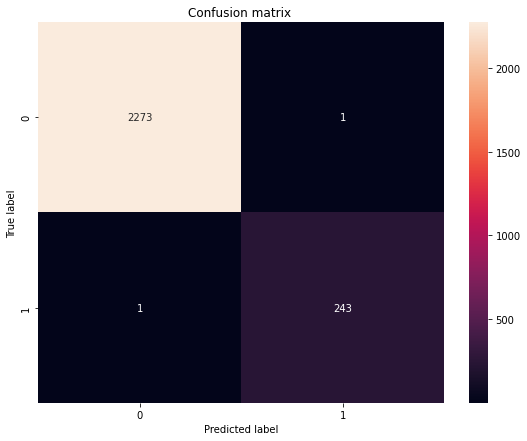

In [16]:
print('acc of testing :',round(accuracy_score(y_test, y_dt),5)*100)
print('------------')
print(classification_report(y_test, y_dt))

plot_conf(y_test, y_dt)


---------
#Consuming from kafka server
-----------

In [17]:
# Make sure that you have the dependency installed on your system
# If not installed, install by running the following
!pip install kafka-python

In [18]:
import time

# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer

#Defining a function to consume packets and converting the packets to dataframe to use it for the static and dynamic case

def consume_from_kafkaServer(number_of_rows=10000):
    # instantiate the KafkaConsumer Class using the arguments mentioned.
    # do not change any arguments other than the first positional argument.
    consumer = KafkaConsumer(
        'task1',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
        bootstrap_servers="34.130.121.39:9092",
        sasl_plain_username="student",
        sasl_plain_password="uottawa",
        security_protocol="SASL_PLAINTEXT",
        sasl_mechanism="PLAIN",
        auto_offset_reset='earliest',
        enable_auto_commit=False
    )


    # Data Stream flowing in.
    list_packest = []
    # Data Stream flowing in.
    i = 1
    for message in consumer:
          # print(f"Consuming the {i+1}th data packet!")
      
          data_packet = message.value
          dict_str = data_packet.decode("UTF-8")
          try:
                  mydata = ast.literal_eval(dict_str)
                  list_packest.append( mydata  )
          except:
                  #print("skip {}".format(i))
                  continue;
          
          if i == number_of_rows:
              #print('x')
              data_converted = pd.DataFrame.from_dict( list_packest )
              break
          i = i + 1
    return data_converted     


----------------
# Static and dynamic case
----------------

In [19]:
def pipeline_static_dynamic(X_train,y_train,X_train2,y_train2,n_rows=10000):
  
  global dt
  global dt2
  global scalar

  n = 100000 // n_rows 
  acc_scores_sta=[]
  f1_scores_sta=[]

  acc_scores_dyn=[]
  f1_scores_dyn=[]
  
  
  for i in range(n):
    data_converted = consume_from_kafkaServer(n_rows)
    #Converting categorical variables to numeric
    
    data_converted["Label"].replace({"ATTACK": 1, "BENIGN": 0}, inplace=True)

        # Replacing infinite with nan
    data_converted.replace([ np.inf , -np.inf ] , np.nan, inplace=True)
      
    # Dropping all the rows with nan values
    data_converted=data_converted.dropna( axis=0, how='any', thresh=None, subset=None, inplace=False)

    X_test_dyn = data_converted.iloc[:, :-1] 
    y_test_dyn = data_converted.iloc[  : , -1] 

    #applying normalization
    
    X_test_dyn = pd.DataFrame(scaler.transform(X_test_dyn))

                # for static case

    #testing the models
    y_dt = dt.predict(X_test_dyn)

    #Metrics
    acc=accuracy_score(y_test_dyn,y_dt)
    f1=f1_score(y_test_dyn,y_dt ,average='weighted')
    
    acc_scores_sta.append(acc)
    f1_scores_sta.append(f1)

   #-------------------------------------------------------------------------

                             # For dynamic case

    #testing the models
    y_dt_dyn = dt2.predict(X_test_dyn)

    #Metrics
    acc2=accuracy_score(y_test_dyn,y_dt_dyn)
    f1_2=f1_score(y_test_dyn,y_dt_dyn ,average='weighted')

    acc_scores_dyn.append(acc2)
    f1_scores_dyn.append(f1_2)

    # Dropping last n rows using drop then concatenating the tested ones
    X_train2.drop(X_train2.tail(n_rows).index,inplace = True)
    X_train2=pd.concat([X_test_dyn, X_train2], ignore_index=True, sort=True)

    y_train2.drop(y_train2.tail(n_rows).index,inplace = True)
    y_train2=pd.concat([y_test_dyn, y_train2], ignore_index=True, sort=True)
    
    #re-training again the algorithm
    dt2.fit(X_train2, y_train2)

    
  return acc_scores_sta,f1_scores_sta,acc_scores_dyn,f1_scores_dyn

  

In [20]:
acc_scores_sta=[]
f1_scores_sta=[]
acc_scores_dyn=[]
f1_scores_dyn=[]

acc_scores_sta , f1_scores_sta , acc_scores_dyn , f1_scores_dyn = pipeline_static_dynamic(X_train,y_train,X_train2,y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ACK Flag Count
- Active Max
- Active Min
- Active Std
- Average Packet Size
- ...
Feature names seen at fit time, yet now missing:
-  ACK Flag Count
-  Active Max
-  Active Min
-  Active Std
-  Average Packet Size
- ...

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ACK Flag Count
- Active Max
- Active Min
- Active Std
- Average Packet Size
- ...
Feature names seen at fit time, yet now missing:
-  ACK Flag Count
-  Active Max
-  Active Min
-  Active Std
-  Average Packet Size
- ...

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-

In [21]:
print('accuracy scores of static :',acc_scores_sta)
print('F1-score: scores of static :',f1_scores_sta)
print('----------------------------------------------------------------------------------------------------------')
print('accuracy scores of Dynamic :',acc_scores_dyn)
print('F1-score: scores of Dynamic :',f1_scores_dyn)

accuracy scores of static : [0.997, 0.9972, 0.9971, 0.9971, 0.9971, 0.9972, 0.9972, 0.9972, 0.9969, 0.9969]
F1-score: scores of static : [0.9969917951075286, 0.997194912450655, 0.9970914026669614, 0.9970914026669614, 0.9970940892045317, 0.9971948649654554, 0.9971948828624578, 0.9971948649654554, 0.9968964856996329, 0.9968950456524013]
----------------------------------------------------------------------------------------------------------
accuracy scores of Dynamic : [0.997, 0.9995, 0.9996, 1.0, 0.9995, 1.0, 0.9998, 0.9999, 0.9998, 0.9995]
F1-score: scores of Dynamic : [0.9969917951075286, 0.9995005635632646, 0.9996003613040971, 1.0, 0.9995003373611704, 1.0, 0.9998000908490954, 0.9999000228045969, 0.9998000903260242, 0.999500113627115]


----
# Plotting the results
-----

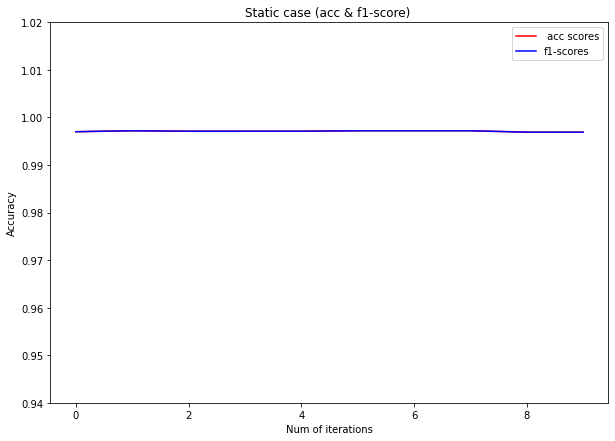

In [26]:
x = list(range(10))


# From here the plotting starts
plt.plot(x, acc_scores_sta, c='r', label=' acc scores')
plt.plot(x, f1_scores_sta, c='b', label='f1-scores')

plt.xlabel('Num of iterations')
plt.ylabel('Accuracy')
plt.title('Static case (acc & f1-score) ')
plt.ylim(0.94, 1.02)
plt.rcParams["figure.figsize"] = (10,7)


plt.legend()
plt.show()

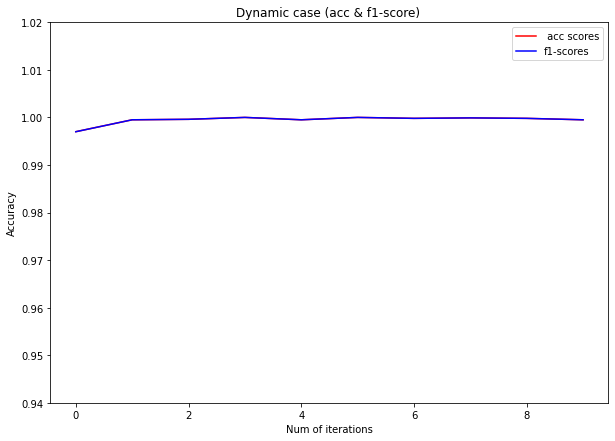

In [23]:

x = list(range(10))


plt.plot(x, acc_scores_dyn, c='r', label=' acc scores')
plt.plot(x, f1_scores_dyn, c='b', label='f1-scores')

plt.xlabel('Num of iterations')
plt.ylabel('Accuracy')
plt.title('Dynamic case (acc & f1-score) ')
plt.ylim(0.94, 1.02)
plt.rcParams["figure.figsize"] = (10,7)


plt.legend()
plt.show()

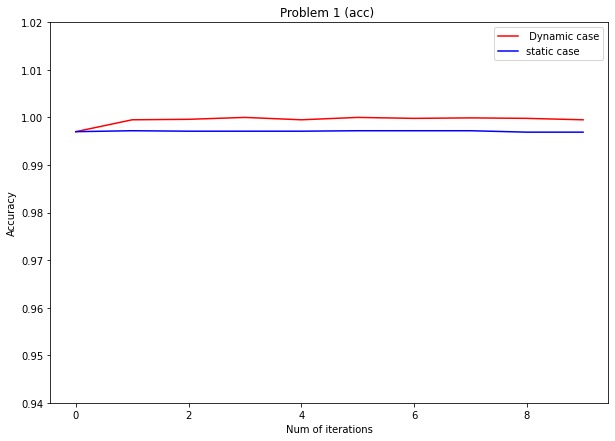

In [24]:

x = list(range(10))

plt.plot(x, acc_scores_dyn, c='r', label=' Dynamic case')
plt.plot(x, acc_scores_sta, c='b', label='static case')

plt.xlabel('Num of iterations')
plt.ylabel('Accuracy')
plt.title('Problem 1 (acc) ') 
plt.ylim(0.94, 1.02)
plt.rcParams["figure.figsize"] = (10,7)


plt.legend()
plt.show()

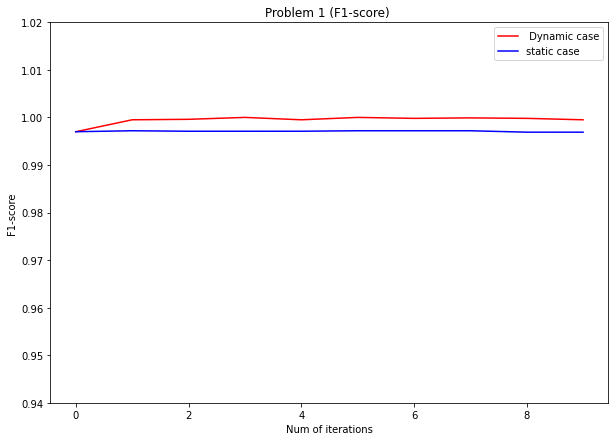

In [25]:
import matplotlib.pyplot as plt

x = list(range(10))


plt.plot(x, f1_scores_dyn, c='r', label=' Dynamic case')
plt.plot(x, f1_scores_sta, c='b', label='static case')

plt.xlabel('Num of iterations')
plt.ylabel('F1-score')
plt.title('Problem 1 (F1-score) ')
plt.ylim(0.94, 1.02)
plt.rcParams["figure.figsize"] = (10,7)


plt.legend()
plt.show()